In [1]:
# %cd ~/src/Sunrise-Demo/
from __future__ import annotations
try:
    from mediocreatbest import auto, run
except ImportError:
    %pip install --quiet --upgrade pip
    %pip install --upgrade --force-reinstall \
        mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
from mediocreatbest import auto, run


In [2]:
SPECIES = "0000172"
DO_SAVE = True
TERRAIN_QUALITY = (
    0
    # 1
    # 2
)
VIDEO_QUALITY = (
#     0
#     1
    2
)

RLO=3300096
RHI=3310591
CLO=2236928
CHI=2259455


## Setup

In [3]:
%%scope
def string_function(arr):
    name = arr.__class__.__name__
    if arr.size < 1024:
        values = auto.numpy.array_repr(auto.numpy.ravel(arr))
    else:
        values = '...'
        
    shape = auto.numpy.shape(arr)
    dtype = arr.dtype
    return f'{name}({values}, {shape=!r}, {dtype=!r})'
auto.numpy.set_string_function(string_function, repr=False)
auto.numpy.set_string_function(string_function, repr=True)

auto.numpy.set_printoptions(
    threshold=4,
    edgeitems=0,
)

### Typing

In [4]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

### Location (lat, lng, alt) to spatial (x, y, z)

In [5]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

### Tile (zoom, x, y) to location (lat, lng)

In [6]:
@auto.mediocreatbest.doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.numpy,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    # r"""

    # >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    # 'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    # """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = 2 ** z
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0

    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.arctan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

### Dataclasses

In [7]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.y,
            y=self.x,
            # z=self.z,
            # x=self.x,
            # y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.y,
            y=1+self.x,
            # z=self.z,
            # x=1+self.x,
            # y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

In [8]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

In [9]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: Degree
    lng: Degree
    alt: Optional[Meter] = auto.dataclasses.field(default=None)

In [10]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: Kilometer
    y: Kilometer
    z: Kilometer

In [11]:
# @dispatch
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Tixel:
    y: int
    x: int
        
    z: ClassVar[int] = 23
        
    @property
    def location(self) -> Location:
        """Center lat/lng of current tixel"""
        lat, lng = tile_coordinates_to_latlng(
            z=1+self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

# @Tixel.register
# def __tixel_from_coord(coord: Coord, /, *, res: int):
#     dz = int(auto.math.log2(Tixel.z - coord.z))
    
    

## Observations

We want to get the observation category, i.e. the percentage. The goal of this section is to get the tile data for a particular species for the "pinks" colormap and assign a category (integer, 0 to 3, inclusive) according to the nearest "pinks" color. The categories are: `0` for 0-25%; `1` for 25-50%; `2` for 50-75%; and `3` for 75-100%.

In [19]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Observation:
    common_name: str
    irma_id: str
    latin_name_ref: str
    latin_name: str

def fetch(url):
    print(f'Fetching: {url}')
    data = auto.requests.get(url).content
    print(data)
    print('done')
    return data

@run
def observations():
    observations = []
    for observation in (
        Observation(**kwargs)
        for kwargs in (
            auto.json.loads(fetch('https://species.atlasofthesmokies.org/atbirecords/lexical_index.json'))
        )['items']
    ):
        observations.append(observation)
    
    return observations

Fetching: https://species.atlasofthesmokies.org/atbirecords/lexical_index.json
b'{"items": [{"common_name": "Red Maple", "irma_id": "0000337", "latin_name_ref": "Acer rubrum v rubrum", "latin_name": "Acer_rubrum_v_rubrum"}, {"common_name": "Sugar Maple", "irma_id": "0000341", "latin_name_ref": "Acer saccharum", "latin_name": "Acer_saccharum"}, {"common_name": "Tuliptree  ", "irma_id": "0023010", "latin_name_ref": "Liriodendron tulipifera", "latin_name": "Liriodendron_tulipifera"}, {"common_name": "Eastern Hemlock", "irma_id": "0041423", "latin_name_ref": "Tsuga canadensis", "latin_name": "Tsuga_canadensis"}, {"common_name": "American Beech", "irma_id": "0016280", "latin_name_ref": "Fagus grandifolia", "latin_name": "Fagus_grandifolia"}, {"common_name": "Virginia Pine", "irma_id": "0031480", "latin_name_ref": "Pinus virginiana", "latin_name": "Pinus_virginiana"}, {"common_name": "Eastern White Pine", "irma_id": "0031478", "latin_name_ref": "Pinus strobus", "latin_name": "Pinus_strobus"}

In [20]:
@run(after=print)
def observation(observations, /):
    for observation in observations:
        if observation.irma_id not in [
            SPECIES,
        ]:
            continue
        
        return observation

Observation(common_name='Greater Red Dart', irma_id='0000172', latin_name_ref='Abagrotis alternata', latin_name='Abagrotis_alternata')


In [21]:
@run(scope='observation')
def db(observation, /):
    @auto.mediocreatbest.contextgenerator(call=lambda generator: lambda sql, /, **parameters: generator.send((sql, parameters)))
    def db(observation: Observation=observation, /):
        root = auto.pathlib.Path('/mnt/seenas2/data/johns_nps_run/maxent/mbtiles/out')
        path = root / f'atlas-user.{observation.irma_id}_pink.mbtiles'
        
        with auto.sqlite3.connect(path) as db:
            db.row_factory = auto.sqlite3.Row
            
            cursor = None
            while True:
                sql, parameters = yield cursor
                cursor = db.execute(sql, parameters)
    
    return db

@run(scope='observation', after=print)
def z():
    z = 15
    return z

@auto.dataclasses.dataclass(eq=True, frozen=True)
class ObservationTile:
    coord: Coord
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='observation', after=lambda tiles: print(f'{len(tiles)=!r}'))
def tiles(db, z, /):
    with db() as db:
        tiles = []
        for tile in db(r'''
            SELECT
                tile_row AS y_tms,
                tile_column AS x,
                zoom_level AS z,
                tile_data AS image
            FROM tiles
            WHERE zoom_level = :z
        ''', z=z):
            tiles.append(ObservationTile(
                coord=Coord(
                    z=tile['z'],
                    y=2 ** tile['z'] - 1 - tile['y_tms'],
                    x=tile['x'],
                ),
                image=tile['image'],
            ))
    
    return tiles

@run(scope='observation', after=print)
def xs(tiles, /):
    return sorted(set(tile.coord.x for tile in tiles))

@run(scope='observation', after=print)
def ys(tiles, /):
    return sorted(set(tile.coord.y for tile in tiles))


15
len(tiles)=918
[8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825]
[12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12917, 12918, 12919, 12920, 12921, 12922, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12930, 12931]


In [22]:
def __stitch_tiles(tiles, /, size: int=128, flip=False):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = size
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        # composite.paste(image, (yi*sz, xi*sz))
        if flip==True:
            composite.paste(image, (yi*sz, xi*sz))
        else:
            composite.paste(image, (xi*sz, yi*sz))
            
    
    return composite

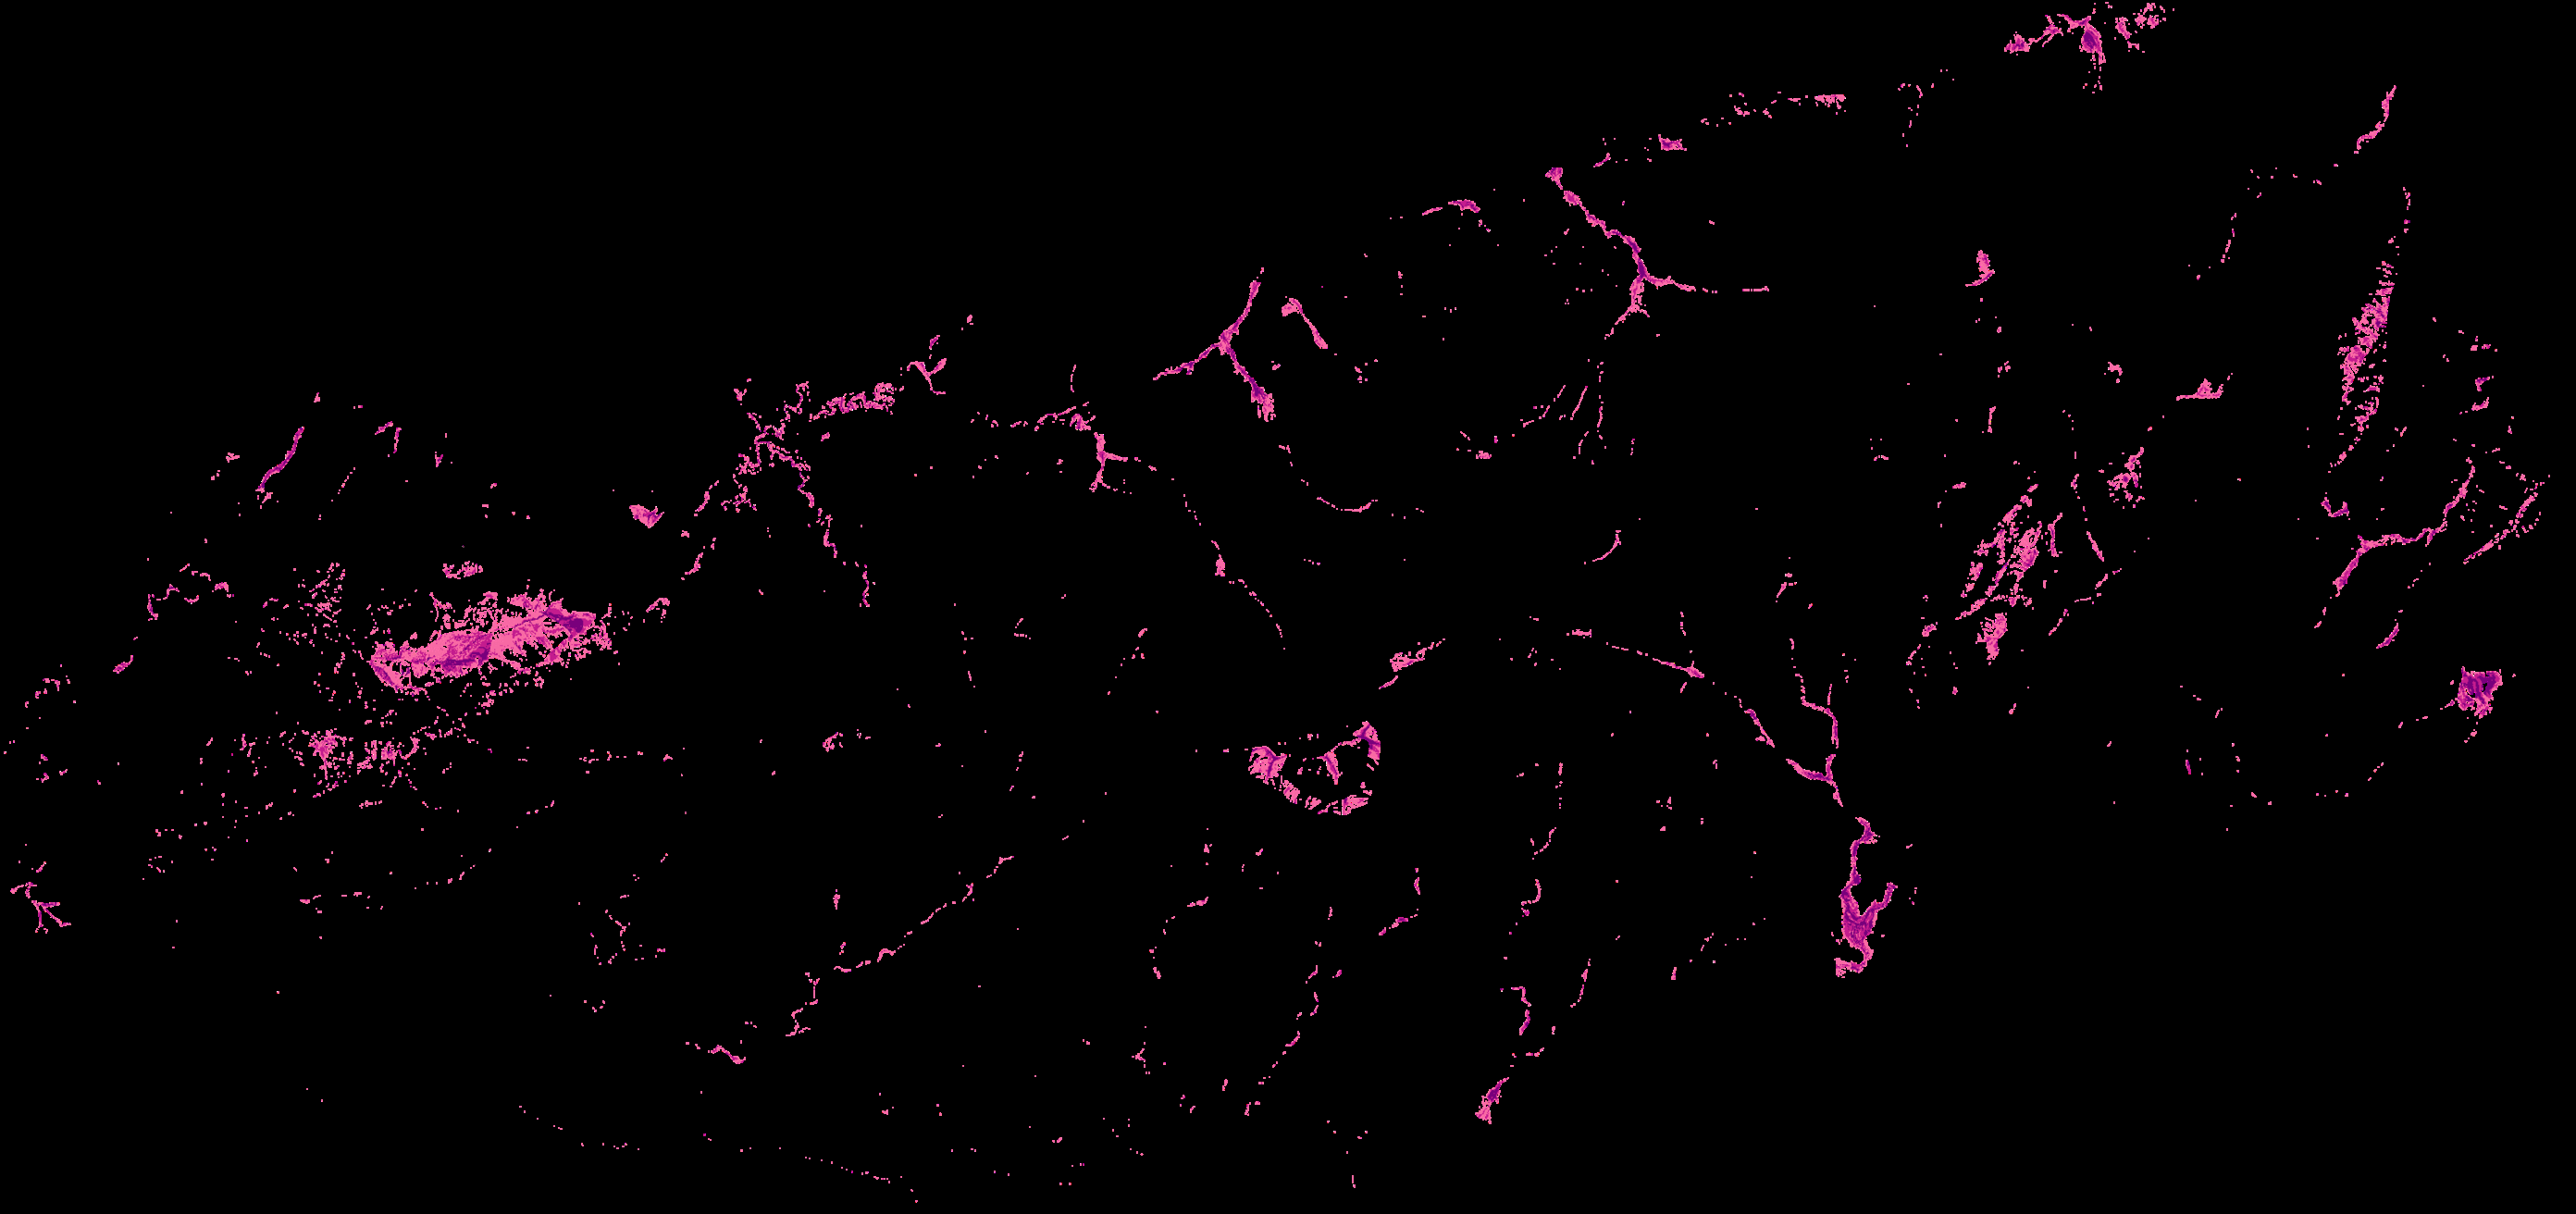

In [23]:
__stitch_tiles(auto.mediocreatbest.g['observation__tiles'], size=32)

In [24]:
@run(scope='observation', cond=False)
def _(tiles, /):
    """Remove redundant pixels from tile data"""
    
    def Image(tile: Tile, /) -> auto.PIL.Image.Image:
        image: bytes = tile.image
        with auto.io.BytesIO(image) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        return image
    
    tile = tiles[9]
    image = Image(tile)
    
    image = auto.numpy.array(image)
    assert len(image.shape) == 3 and image.shape[-1] == 4, \
        f"""Wrong shape: {image.shape=!r}"""
    NR, NC, _ = image.shape

    image = image[:NR, :NC, 0]
    
    auto.IPython.display.display(image)
    
    raise NotImplementedError

points[0][[0, -1]]=ndarray(array([3300096, 3310591]), shape=(2,), dtype=dtype('int64'))
points[1][[0, -1]]=ndarray(array([2237184, 2259455]), shape=(2,), dtype=dtype('int64'))


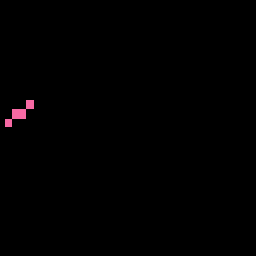

100%|██████████| 3567/3567 [00:14<00:00, 252.86it/s]


In [25]:
@run(scope='observation')
def interpolator(tiles, z, xs, ys, /):
    res = 256
    
    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)
    
    @auto.mediocreatbest.coroutine
    def display():
        handle = auto.IPython.display.display(None, display_id=True)
        
        while True:
            obj = yield
            handle.update(obj)
        
    @auto.mediocreatbest.coroutine  # (call=lambda gen: lambda *, z, x, y: gen.send((z, x, y)))
    def category() -> Generator[Optional[auto.numpy.ndarray], tuple[float, float, float], None]:
        category = None
        while True:
            coord = yield category
            
            for tile in tiles:
                if tile.coord == coord:
                    break
            
            else:
#                 print(f'No tile found: {coord=!r}')
                category = None
                continue

#             (exists,) ,= db(r'''
#                 SELECT EXISTS(SELECT 1 FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y)
#             ''', z=z, x=x, y=y)

#             if not exists:
#                 category = None
#                 continue

#             (image,) ,= db(r'''
#                 SELECT tile_data FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y
#             ''', z=z, x=x, y=y)

            with auto.io.BytesIO(tile.image) as f:
                image = auto.PIL.Image.open(f)
                image.load()
            
            image = image.convert('RGB')
            image = yield image

            rgb = auto.numpy.array(image)

            assert rgb.shape == (res, res, 3), \
                f"""Wrong shape for observation tile image: {rgb.shape=!r}"""

            rgb = rgb.reshape((res*res, 3))

            diffs = auto.numpy.subtract(rgb[:, None, :], pinks[None, :, :], dtype=auto.numpy.float32)
            assert diffs.shape == (res*res, len(pinks), 3)

            dists = auto.numpy.linalg.norm(diffs, axis=-1)
            assert dists.shape == (res*res, len(pinks))

            category = auto.numpy.argmin(dists, axis=-1)
            assert category.shape == (res*res,), \
                f"""Wrong shape: {category.shape=!r}"""

            category = category.astype(auto.numpy.uint8)
            category = category.reshape((res, res))

    @auto.mediocreatbest.coroutine
    def debounce(coroutine, /, *, rate: 'item/seconds'):
        def now() -> 'seconds':
            return auto.time.clock_gettime(auto.time.CLOCK_MONOTONIC)
        
        prev = float('-inf')
        while True:
            value = yield
            if (curr := now()) - prev > 1.0 / rate:
                prev = curr
                coroutine.send(value)
    
    dz = int(auto.math.log2(res))
    assert z + dz == Tixel.z
    points = (
        auto.numpy.arange(
            (min(ys) + 0) * 2 ** dz,
            (max(ys) + 1) * 2 ** dz,
        ),
        auto.numpy.arange(
            (min(xs) + 0) * 2 ** dz,
            (max(xs) + 1) * 2 ** dz,
        ),
    )
    print(f'{points[0][[0, -1]]=!r}')
    print(f'{points[1][[0, -1]]=!r}')
    
    values = auto.numpy.zeros(
        shape=(
            len(ys)*res,
            len(xs)*res,
        ),
        dtype=auto.numpy.uint8,
    )
    
    with auto.contextlib.ExitStack() as stack:
        category = stack.enter_context( auto.contextlib.closing(category()) )
        display = stack.enter_context( auto.contextlib.closing(display()) )
        display = stack.enter_context(auto.contextlib.closing( debounce(display, rate=1) ))
        
        for (yi, y), (xi, x) in auto.tqdm.tqdm(auto.itertools.product(
            enumerate(ys),
            enumerate(xs),
        ), total=len(ys)*len(xs)):
            image = category.send(Coord(
                z=z,
                x=x,
                y=y,
            ))

            if image is None:
                continue
            
            display.send(image)
            
            src = category.send(image)
                
            values[
                slice(
                    (yi + 0) * res,
                    (yi + 1) * res,
                ),
                slice(
                    (xi + 0) * res,
                    (xi + 1) * res,
                ),
            ] = src
    
    return auto.scipy.interpolate.RegularGridInterpolator(
        points=points,
        values=values,
        method='nearest',
        bounds_error=False,
        fill_value=0,
    )

In [26]:
auto.mediocreatbest.g['observation__interpolator'].grid[0][[0, -1]]

ndarray(array([3300096., 3310591.]), shape=(2,), dtype=dtype('float64'))

len(arr)=10496
len(arr)=22272


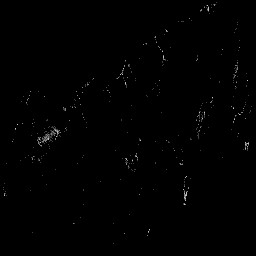

In [27]:
@run(scope='observation')
def __view(interpolator, /):
    rs, cs = interpolator.grid
    
    def decimate(
        arr: auto.numpy.ndarray,
        /,
        *,
        length: int,
    ) -> auto.numpy.ndarray:
        print(f'{len(arr)=!r}')
        stride = int(auto.math.floor( len(arr) / length ))
        arr = arr[::stride]
        arr = arr[:length]
        return arr
    
    rs = decimate(rs, length=256)
    cs = decimate(cs, length=256)
    
    grid = auto.numpy.hstack(tuple(
        v.reshape((-1, 1))
        for v in auto.numpy.meshgrid(
            rs,
            cs,
            indexing='ij',
        )
    ))
    assert grid.shape == (len(rs) * len(cs), 2)
    
    confidence = (interpolator(grid, method='linear') * 255.0 / 4.0).astype(auto.numpy.uint8)
    confidence = confidence.reshape((len(rs), len(cs)))
    
    image = auto.PIL.Image.fromarray(confidence, mode='L')
    
    auto.IPython.display.display(image)

r=3305001 c=2250075


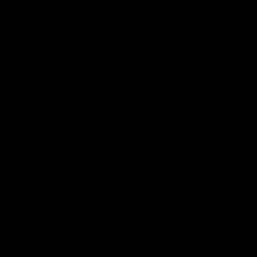

In [28]:
## @Tile.from_.register(Location)
@auto.mediocreatbest.doctest
def convert_location_to_tile(*, lat: Degree, lng: Degree, zoom: int, math=auto.math) -> tuple[int, int]:
    r"""
    
    >>> convert_location_to_tile(lat=35.6, lng=-83.52, zoom=11)
    (807, 548)
    >>> convert_location_to_tile(lat=35.0, lng=-84.5, zoom=15)
    (12979, 8692)
    >>> convert_location_to_tile(lat=36.25, lng=-82.5, zoom=15)
    (12839, 8874)
    
    """
    # Thanks https://stackoverflow.com/a/72476578
    
    #> lat_rad = math.radians(lat_deg)
    lat_rad = math.radians(lat)
    
    #> n = 2.0 ** zoom
    n = 2.0 ** zoom
    
    #> xtile = int((lon_deg + 180.0) / 360.0 * n)
    col = int((lng + 180.0) / 360.0 * n)
    
    #> ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    row = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    
    #> return (xtile, ytile)
    return row, col


@run(scope='observation')
def __view(interpolator, /):
    lat, lng = (
        (35.6201452, -83.4372325)  # Clingman's Dome
    )
    
    r, c = convert_location_to_tile(
        lat=lat,
        lng=lng,
        zoom=Tixel.z,
    )
    print(f'{r=!r} {c=!r}')
    
    k = 2
    rs = auto.numpy.arange(r-k*128, r+k*128+1, k)
    cs = auto.numpy.arange(c-k*128, c+k*128+1, k)
    
#     rs, cs = interpolator.grid
    
#     def decimate(
#         arr: auto.numpy.ndarray,
#         /,
#         *,
#         length: int,
#     ) -> auto.numpy.ndarray:
#         print(f'{len(arr)=!r}')
#         stride = int(auto.math.floor( len(arr) / length ))
#         arr = arr[::stride]
#         arr = arr[:length]
#         return arr
    
#     rs = decimate(rs, length=256)
#     cs = decimate(cs, length=256)
    
    grid = auto.numpy.hstack(tuple(
        v.reshape((-1, 1))
        for v in auto.numpy.meshgrid(
            rs,
            cs,
            indexing='ij',
        )
    ))
    assert grid.shape == (len(rs) * len(cs), 2)
    
    confidence = (interpolator(grid, method='linear').astype(auto.numpy.float32) * 255.0 / 4.0).astype(auto.numpy.uint8)
    confidence = confidence.reshape((len(rs), len(cs)))
    
    image = auto.PIL.Image.fromarray(confidence, mode='L')
    
    auto.IPython.display.display(image)
    

## Visualize

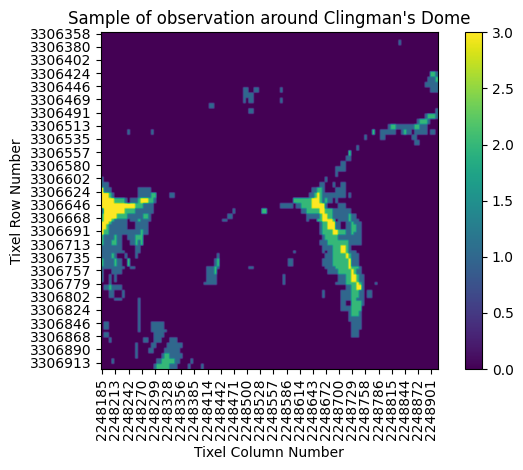

In [29]:
@run
def __visualize(observation__interpolator, /):
    def visualize(
        *,
        name: str,
        interpolator: auto.scipy.interpolate.RegularGridInterpolator,
        num: int,
    ):
        lat0, lng0 = 35.572785, -83.518351
        lat1, lng1 = 35.553081, -83.487097
        
        r0, c0 = convert_location_to_tile(
            lat=lat0,
            lng=lng0,
            zoom=Tixel.z,
        )
        
        r1, c1 = convert_location_to_tile(
            lat=lat1,
            lng=lng1,
            zoom=Tixel.z,
        )
        
        rlo, rhi = min(r0, r1), max(r0, r1)
        clo, chi = min(c0, c1), max(c0, c1)

        # real_rlo = interpolator.grid[0].min()
        # real_rhi = interpolator.grid[0].max()
        # real_clo = interpolator.grid[1].min()
        # real_chi = interpolator.grid[1].max()
        # assert rlo >= real_rlo, \
        #     f'{rlo=!r} < {real_rlo=!r}'
        # assert rhi <= real_rhi, \
        #     f'{rhi=!r} > {real_rhi=!r}'
        # assert clo >= real_clo, \
        #     f'{clo=!r} < {real_clo=!r}'
        # assert chi <= real_chi, \
        #     f'{chi=!r} > {real_chi=!r}'

    # rs = auto.numpy.arange(rlo, rhi)
    # cs = auto.numpy.arange(clo, chi)

        
        rs = auto.numpy.linspace(rlo, rhi, num=num)
        cs = auto.numpy.linspace(clo, chi, num=num)
        
        grid = auto.numpy.hstack(tuple(
            v.reshape((-1, 1))
            for v in auto.numpy.meshgrid(
                rs,
                cs,
                indexing='ij',
            )
        ))
        assert grid.shape == (len(cs)*len(rs), 2), \
            f"""Wrong shape: {grid.shape=!r}"""
        
        values = interpolator(grid)
        values = values.reshape((len(rs), len(cs), -1))
        
        %matplotlib inline
        plt = auto.matplotlib.pyplot
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(values)
        ax.set_yticks(auto.numpy.arange(0, len(rs), 5))
        ax.set_yticklabels([f'{int(r)}' for r in rs[::5]], rotation=0)
        ax.set_xticks(auto.numpy.arange(0, len(cs), 5))
        ax.set_xticklabels([f'{int(c)}' for c in cs[::5]], rotation=90)
        
        ax.set_title(f"Sample of {name} around Clingman's Dome")
        ax.set_xlabel('Tixel Column Number')
        ax.set_ylabel('Tixel Row Number', rotation=90)
        
        fig.colorbar(im)
        fig.tight_layout()
        plt.show()
    
    visualize(
        name='observation',
        interpolator=observation__interpolator,
        num=128,
    )
 
    

### Save

In [30]:
@run
def __save(observation__interpolator, /):
    def save(
        *,
        name: str,
        interpolator: auto.scipy.interpolate.RegularGridInterpolator,
    ):
        path = auto.pathlib.Path.cwd() / 'temp' / f'park-{name}.npz'
        auto.numpy.savez_compressed(
            path,
            points0=interpolator.grid[0],
            points1=interpolator.grid[1],
            values=interpolator.values,
        )
        
        print(f'Wrote {path.stat().st_size :,d} bytes to {path}')
    
   
    save(
        name=f'observation_{SPECIES}',
        interpolator=observation__interpolator,
    )



Wrote 2,412,343 bytes to /home/raustin9/src/Sunrise-Demo-Dev/temp/park-observation_0000172.npz


## Observation

In [38]:
@run(scope='render', after=print)
def observation(observation__interpolator, /) -> 'uint8[]':
    """OSPGeometricModel::index:uint8[]"""
    
    def Data(array: auto.numpy.ndarray, /, *, type: lib.OSPDataType) -> lib.OSPData:
        if len(array.shape) == 0:
            array = array[None, None, None]

        elif len(array.shape) == 1:
            array = array[:, None, None]

        elif len(array.shape) == 2:
            array = array[:, :, None]
            
        elif len(array.shape) == 3:
            array = array[:, :, :]

        else:
            raise NotImplementedError()

        src = lib.ospNewSharedData(
            array.ctypes.data, type,
            array.shape[0], array.strides[0],
            array.shape[1], array.strides[1],
            array.shape[2], array.strides[2],
        )
        lib.ospCommit(src)

        dst = lib.ospNewData(type, *array.shape)
        lib.ospCopyData(src, dst, 0, 0, 0)
        lib.ospCommit(dst)

        lib.ospRelease(src)
        return dst
    
  
    

    rs = auto.numpy.arange(RLO, RHI)
    cs = auto.numpy.arange(CLO, CHI)
    # rs = auto.numpy.aran

    def decimate(
        rs: auto.np.ndarray,
        cs: auto.np.ndarray,
        /,
        *,
        duration: 'seconds',
        rate: 'item/s',
    ) -> tuple[auto.np.ndarray, auto.np.ndarray]:
        total_items = len(rs) * len(cs)

        actual_items = duration * rate
    #             print(f'{items = } = {duration} * {rate}')

        factor_items = total_items / actual_items

        stride = int(auto.math.ceil(auto.math.sqrt( factor_items )))

    #             stride = int(auto.math.ceil())
    #             print(f'{stride = } = int(auto.math.ceil( {len(rs)} / {items} == {len(rs)/items} ))')

        rs = rs[::stride]
        cs = cs[::stride]

        print(f'Decimate by factor of {stride}**2={stride**2 :,d} from {total_items :,d} to {len(rs)*len(cs) :,d} vertices')
        return rs, cs

    rs, cs = decimate(
        rs, cs,
        duration=[
            1,  # lo resolution
            10,  # medium resolution
            1000,  # high resolution
        ][TERRAIN_QUALITY],
        rate=6260094,
    )
    
    index = auto.numpy.zeros(
        shape=(len(rs), len(cs)),
        dtype='u1',
    )
    
    for (ri, r) in enumerate(auto.tqdm.autonotebook.tqdm(rs, unit='row')):
        grid = auto.numpy.hstack(tuple(
            v.reshape((-1, 1))
            for v in auto.numpy.meshgrid(
                [r],
                cs,
                indexing='ij',
            )
        ))
        assert grid.shape == (len(cs), 2), \
            f"""Wrong shape: {grid.shape=!r}"""
#             print(f"""{grid[:, 0].min()=!r} ;; {grid[:, 0].max()=!r}
# {grid[:, 1].min()=!r} ;; {grid[:, 1].max()=!r}""")
        
        try:
            observation__interpolator.fill_value = 0
            category = observation__interpolator(
                grid,
                method='nearest',
            )
            # interpolate.observation.fill_value = 0
            # category = interpolate.observation(
            #     grid,
            #     method='nearest',
            # )
        except ValueError:
            print(f'{grid.shape=!r}')
            print(f'{auto.np.min(grid, axis=0)=!r}')
            print(f'{auto.np.max(grid, axis=0)=!r}')
            raise

        assert category.shape == (len(cs),), \
            f"""Wrong shape: {category.shape=!r}"""
        assert auto.numpy.all((0 <= category) & (category < 4))
        
        index[ri, :] = category
    
    index = index.reshape((-1,))
    print(auto.collections.Counter(index.flat))
    
    
    #--- Save to Disk

    def Save(data: auto.numpy.NDArray, /, *, path: auto.pathlib.Path):
        if not DO_SAVE:
            return
        
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, 'wb') as f:
            f.write(auto.struct.pack('I', len(data.shape)))
            f.write(auto.struct.pack(f'{len(data.shape)}I', *data.shape))
            data.tofile(f)
        print(f"Wrote {path.stat().st_size :,d} bytes to {path}")

    Save(
        index,
        path=auto.pathlib.Path.cwd().joinpath(
            f"data",
            f"observations",
            f"observation_{SPECIES}",
            f"OSPGeometricModel.index.vec1uc.bin",
        ),
    )
    

Decimate by factor of 7**2=49 from 236,420,865 to 4,828,500 vertices


  0%|          | 0/1500 [00:00<?, ?row/s]

Counter({0: 4777246, 1: 31529, 2: 14259, 3: 5466})
Wrote 4,828,508 bytes to /home/raustin9/src/Sunrise-Demo-Dev/data/observations/observation_0000172/OSPGeometricModel.index.vec1uc.bin
None
